# Transfer learning based on online tutorials
This notebook explores transfer learning. 

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os

from IPython.display import SVG
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

/home/peter/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config
# to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [20]:
# variables
input_channels = 3
input_height, input_width = 256, 256

# data
data_train_dir = 'images/train/'
data_validation_dir = 'images/validation/'
n_classes = 4
n_train = 20
n_validation = 10

# output
output_checkpoint_dir = 'checkpoint/from-tutorial-1.h5'
output_diagram_dir = 'diagram/from-tutorial-1.png'
output_logs_dir = 'logs/'

# hyperparameters
batch_size = 5
freeze_layers = None
epochs = 1

## Create Data Generators
The images should be stored in the following directory structure:  
images:  
   - test:  
       - category_0:  
       - category_1:  
       - category_2:  
       - category_3:  
   - validation:  
       - category_0:  
       - category_1:  
       - category_2:  
       - category_3:        

In [4]:
# define data generators
train_datagen = ImageDataGenerator()

validation_datagen = ImageDataGenerator()

# initialize them
train_generator = train_datagen.flow_from_directory(data_train_dir,
                                                    target_size=(input_height, input_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(data_validation_dir,
                                                              target_size=(input_height, input_width),
                                                              class_mode='categorical')

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


## Load VGG19

In [5]:
# load the VGG19 network with it's pretrained weights
# include_top refers to the fully connected layers. We don't need this part because we will add our own
# we need to specify the shape of our inputs
model = applications.VGG19(weights='imagenet',
                           include_top=False,
                           input_shape=(input_width, input_height, input_channels))

In [6]:
# examine the loaded model
# we should see that the loaded model has the FC layers + softmax removed
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [7]:
# Freeze the layers we don't want to train. To start, lets freeze all of them... just to see if this works.
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

In [8]:
# examine the layers and check that they are frozen correctly
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f92b95d3048> False
<keras.layers.convolutional.Conv2D object at 0x7f92b95d35c0> False
<keras.layers.convolutional.Conv2D object at 0x7f92b95d3320> False
<keras.layers.pooling.MaxPooling2D object at 0x7f92b95d3198> False
<keras.layers.convolutional.Conv2D object at 0x7f92b9609b00> False
<keras.layers.convolutional.Conv2D object at 0x7f93310b7e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f93310ca748> False
<keras.layers.convolutional.Conv2D object at 0x7f9331076470> False
<keras.layers.convolutional.Conv2D object at 0x7f9331076e48> False
<keras.layers.convolutional.Conv2D object at 0x7f933109dd30> False
<keras.layers.convolutional.Conv2D object at 0x7f9331032b00> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9331058dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f9330dc6cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f9330dda278> False
<keras.layers.convolutional.Conv2D object at 0x7f9330dedfd0> Fa

## Add custom layers

In [9]:
# build our custom layers
# take the output of the loaded model (some x, some y, some c)
x = model.output 

# flatten it so that we can feed it to fully connected layers
x = Flatten(name='flatten')(x)

# feed into a fc layer with a relu activation and output 1024 units
x = Dense(1024, activation='relu', name='fc_1')(x)

# use dropout for a normalizing effect
x = Dropout(0.5, name='do_1')(x)

# feed into a fc layer with a relu activation and output 1024 units
x = Dense(1024, activation='relu', name='fc_2')(x)

# feed into a softmax to make final predictions of n_classes
predictions = Dense(n_classes, activation='softmax', name='prediction')(x)

In [10]:
# create the model
model = Model(input=model.input, output=predictions)

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


In [11]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

In [12]:
# examine our model with our custom layers.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

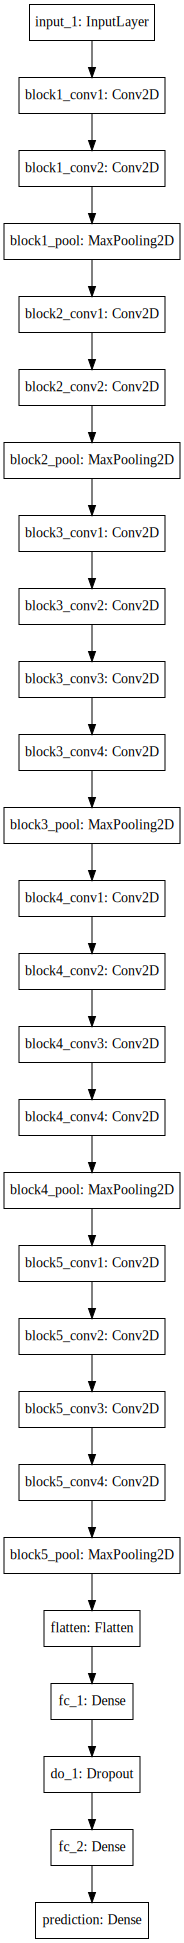

In [13]:
# draw a diagram of the model and save it disk
plot_model(model, to_file=output_diagram_dir)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train model

In [18]:
# Save the model and use early stopping
checkpoint = ModelCheckpoint(output_checkpoint_dir, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

tensorboard = TensorBoard(log_dir=output_logs_dir)

In [19]:
# train the model
model.fit_generator(train_generator,
                    steps_per_epoch=n_train/batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=n_validation,
                    callbacks=[checkpoint, early, tensorboard])

Epoch 1/10


KeyboardInterrupt: 

## References
[Transfer Learning using Keras](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8)